In [10]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# CONSTANTES
BATCH_SIZE = 32
IMG_SIZE = 32
NUM_CLASSES = 10  # nº classes para identificar
NUM_EPOCHS = 60
LEARNING_RATE = 0.001

In [12]:
# Define directories
train_dirs = ['./dataset/train/train1', './dataset/train/train2', './dataset/train/train3', './dataset/train/train5']
validation_dir = './dataset/validation'
test_dir = './dataset/test'

In [13]:
# CRIAR OS GERADORES
train_datagen = ImageDataGenerator(rescale=1./255)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# training generators
train_generators = [train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical') for train_dir in train_dirs]

# Necessário para juntar os trainning generators
def combined_generator(generators):
    while True:
        for generator in generators:
            yield next(generator)

train_generator = combined_generator(train_generators)

# Validation e test generators
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 10000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


In [14]:
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import Metric

class Precision(Metric):
    def __init__(self, name='precision', **kwargs):
        super(Precision, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.predicted_positives = self.add_weight(name='pp', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = K.round(y_pred)
        y_true = K.cast(y_true, 'float32')
        self.true_positives.assign_add(K.sum(y_true * y_pred))
        self.predicted_positives.assign_add(K.sum(y_pred))

    def result(self):
        return self.true_positives / (self.predicted_positives + K.epsilon())

    def reset_states(self):
        self.true_positives.assign(0)
        self.predicted_positives.assign(0)

class Recall(Metric):
    def __init__(self, name='recall', **kwargs):
        super(Recall, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.actual_positives = self.add_weight(name='ap', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = K.round(y_pred)
        y_true = K.cast(y_true, 'float32')
        self.true_positives.assign_add(K.sum(y_true * y_pred))
        self.actual_positives.assign_add(K.sum(y_true))

    def result(self):
        return self.true_positives / (self.actual_positives + K.epsilon())

    def reset_states(self):
        self.true_positives.assign(0)
        self.actual_positives.assign(0)

class F1Score(Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred)
        self.recall.update_state(y_true, y_pred)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()


In [15]:
model = Sequential([
    Conv2D(128, (3, 3), input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    
    Conv2D(256, (3, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    
    Conv2D(512, (3, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    
    Flatten(),
    Dense(512),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    
    Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model
model.compile(optimizer=RMSprop(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall(), F1Score()])


model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 128)       3584      
                                                                 
 batch_normalization_4 (Batc  (None, 30, 30, 128)      512       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 30, 30, 128)       0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 15, 15, 128)      0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 15, 15, 128)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 256)      

In [16]:
# Definir os Callbacks

# Para salvar o melhor modelo com base na acurácia de validação
checkpoint = ModelCheckpoint("models/modelo_S_sem_data_augmentation_rmsprop.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Parar o treinamento se não houver melhoria na loss após x epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Salvar para csv
csv_logger = CSVLogger(f'logs/modelo_S_sem_data_augmentation_rmsprop.csv', append=True)

# Reduzir a learning rate se não houver melhoria na loss após x epochs (lembrar de deixar este valor sempre menor que a patience no early_stopping!!)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

In [17]:
# Calculate steps per epoch
steps_per_epoch = sum([gen.samples // BATCH_SIZE for gen in train_generators])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=NUM_EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[checkpoint, early_stopping, csv_logger, reduce_lr]
)


# Evaluate the model
results = model.evaluate(test_generator)
loss, accuracy, precision, recall, f1_score = results[:5]
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test F1 Score: {f1_score}")


Epoch 1/60
1247/1248 [============================>.] - ETA: 0s - loss: 1.6157 - accuracy: 0.4412 - precision: 0.5710 - recall: 0.2937 - f1_score: 0.3879
Epoch 1: val_accuracy improved from -inf to 0.52334, saving model to models\modelo_S_sem_data_augmentation_rmsprop.keras
1248/1248 [==============================] - 20s 15ms/step - loss: 1.6155 - accuracy: 0.4413 - precision: 0.5710 - recall: 0.2937 - f1_score: 0.3879 - val_loss: 1.3149 - val_accuracy: 0.5233 - val_precision: 0.7239 - val_recall: 0.3285 - val_f1_score: 0.4519 - lr: 0.0010
Epoch 2/60
1246/1248 [============================>.] - ETA: 0s - loss: 1.2480 - accuracy: 0.5652 - precision: 0.6983 - recall: 0.4235 - f1_score: 0.5273
Epoch 2: val_accuracy did not improve from 0.52334
1248/1248 [==============================] - 18s 14ms/step - loss: 1.2483 - accuracy: 0.5651 - precision: 0.6982 - recall: 0.4235 - f1_score: 0.5272 - val_loss: 1.4336 - val_accuracy: 0.5173 - val_precision: 0.7833 - val_recall: 0.2459 - val_f1_sco

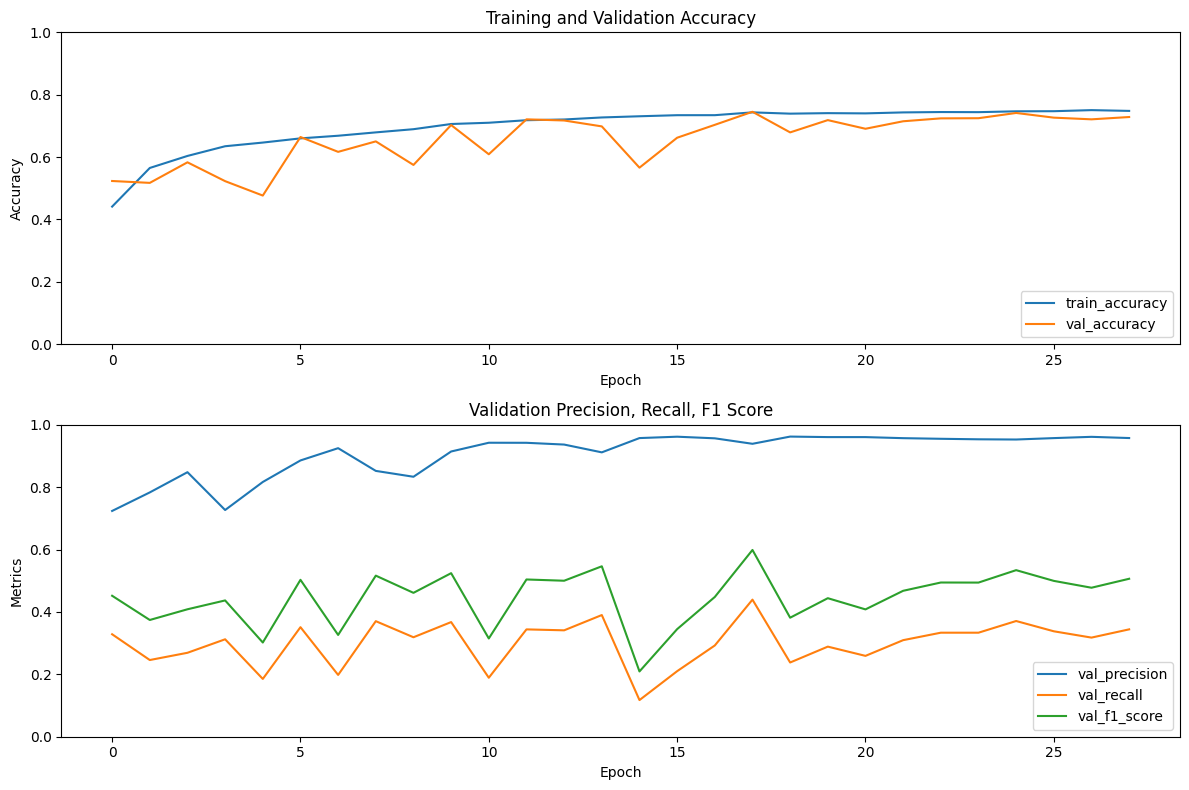

In [18]:
# Plot training history
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(history.history['val_precision'], label='val_precision')
plt.plot(history.history['val_recall'], label='val_recall')
plt.plot(history.history['val_f1_score'], label='val_f1_score')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Validation Precision, Recall, F1 Score')

plt.tight_layout()
plt.savefig(f'./plots/modelo_S_sem_data_augmentation_rmsprop_rmsprop.png')
plt.show()